# Imports

In [1]:
# import pycuda.driver as cuda
# import pycuda.autoinit
# from pycuda.compiler import SourceModule

%load_ext autoreload
%autoreload 2

import os
import errno
import shutil
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import tensorflow as tf
import cv2

from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import (accuracy_score, plot_roc_curve, auc, 
                             confusion_matrix, roc_auc_score, roc_curve)

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

tf.test.gpu_device_name()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


''


# Manage files

In [2]:
!rm -r data
!rm -r train
!rm -r test

rm: cannot remove 'data': No such file or directory
rm: cannot remove 'train': No such file or directory
rm: cannot remove 'test': No such file or directory


In [3]:
def create_folders():
  root = 'data/'

  # Creating directories
  try:
      os.mkdir(root)
      os.mkdir('train')
      os.mkdir('test')
  except OSError as e:
      if e.errno == errno.EEXIST:
          print('Directory already exist')
      else:
          raise

  # Copying zip files
  shutil.copy('/content/drive/MyDrive/sdw_classification/datasets/not_processed/metal.zip',
              '/content/data')
  shutil.copy('/content/drive/MyDrive/sdw_classification/datasets/not_processed/cardboard.zip',
              '/content/data')
  
  # Unziping the files
  with zipfile.ZipFile('/content/data/metal.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')
  with zipfile.ZipFile('/content/data/cardboard.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

  # Removing zip folders
  os.remove('/content/data/metal.zip')
  os.remove('/content/data/cardboard.zip')

In [4]:
create_folders()

# Preprocessing functions


## Edges

In [ ]:
def edges(img):
  img = np.float32(tf.squeeze(img))
  # Blurring 
  blurred = cv2.bilateralFilter(img,15,150,150)

  v = np.median(blurred)
  sigma = 0.33

  lower = int(max(0,(1-sigma)*v))
  upper = int(min(255,(1+sigma)*v))

  img = np.uint8(img)

  edged = tf.convert_to_tensor(cv2.Canny(img,lower,upper),dtype=tf.float32)
  x , y = edged.shape
  edged = tf.reshape(edged,[x,y,1])
  # edged.shape = (edged.shape[0],edged.shape[1],1)

  return edged

## Discrete Fourier Transform


In [ ]:
def dft(img):
  return tf.signal.rfft2d(img)

In [ ]:
# x_images = []
# y_label = []

# root = 'data/'

# for label in sorted(os.listdir(root)):
#   if os.path.isdir(root + label):
#     print(label'{label} is a target class')
#     for image in sorted(os.listdir(root+label)):


In [ ]:
# image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
#                                                                   validation_split=0.2,
#                                                                   preprocessing_function = edges)

# image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
#                                                                   validation_split=0.2)

# image_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

# image_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

# dims = 10

# Processing techniques included
# data_gen = image_generator.flow_from_directory(directory='data', 
#                                                     target_size=(dims, dims),
#                                                   color_mode = "grayscale",
#                                                   save_format='webp',
#                                                   batch_size = 70)

# train_data_gen = image_generator.flow_from_directory(directory='data', 
#                                                     save_to_dir='train',
#                                                     target_size=(dims, dims),
#                                                   save_prefix='train',
#                                                   color_mode = "grayscale",
#                                                   save_format='webp',
#                                                   subset='training',
#                                                   batch_size = 32)

# val_data_gen = image_generator.flow_from_directory(directory='data',
#                                                   save_to_dir='test',
#                                                   target_size=(dims, dims),
#                                                   color_mode = "grayscale",
#                                                   save_prefix='ts',
#                                                   save_format='webp',
#                                                   subset='validation',
#                                                   batch_size = 32)

Found 813 images belonging to 2 classes.


In [ ]:
# # Shape dimensions
# d1 = images_tr.shape[3]

# # Flattening
# Xtr = []

# for i in range(0, images_tr.shape[0]):
#   image =images_tr[i][:, :, 0]
#   X_train = np.reshape(image, (1, d1*dims*dims))[0]
#   Xtr.append(X_train)

# Xts = []

# for i in range(0, images_ts.shape[0]):
#   images =images_ts[i][:, :, 0]
#   Xs_train = np.reshape(images, (1, d1*dims*dims))[0]
#   Xts.append(Xs_train)

# # Data separation
# x_train = pd.DataFrame(Xtr)
# x_test = pd.DataFrame(Xts)

# y_train = label_tr[:,0]
# y_test = label_ts[:,0]

# Data preparation

In [5]:
# Image Generator
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)
dims = 10

# Processing techniques included
data_gen = image_generator.flow_from_directory(directory='data', 
                                                    target_size=(dims, dims),
                                                  color_mode = "grayscale",
                                                  save_format='webp',
                                                  batch_size = 70)

Found 813 images belonging to 2 classes.


In [6]:
# Extracting train and test images and labels
images, label = data_gen.next()

# Converting label into a Dataframe for easier management
y = pd.DataFrame(label)

# Homogenizing sample by eliminating extra samples
c1 = sum(y[0])
c2 = len(y)-c1
num_images = int(min(c1,c2))
c1_images = images[y[y[0] == 1].index.tolist()[:num_images]]
c1_label = label[y[y[0] == 1].index.tolist()[:num_images]]
c2_images = images[y[y[0] == 0].index.tolist()[:num_images]]
c2_label = label[y[y[0] == 0].index.tolist()[:num_images]]

# Concatenating samples
balanced_images = np.concatenate((c1_images,c2_images))
balanced_label = np.concatenate((c1_label,c2_label))

# Shape dimensions
d1 = balanced_images.shape[3]

# Flattening
X = []

for i in range(0, balanced_images.shape[0]):
  image = balanced_images[i][:, :, 0]
  X_train = np.reshape(image, (1, d1*dims*dims))[0]
  X.append(X_train)

X = pd.DataFrame(X)
y = pd.DataFrame(balanced_label)

print(X.shape)
print(y.shape)
print(num_images)

(62, 100)
(62, 2)
31


# Decomposition

## PCA

In [7]:
def applypca(X):

  pca = PCA()

  X_pca = pca.fit_transform(X)

  return (X_pca,pca)

In [8]:
(X_pca,pca) = applypca(X)

print(X.shape)
print(X_pca.shape)

(62, 100)
(62, 62)


## NMF

In [ ]:
def applynmf(x_train,x_test):
  flag = x_train.shape[0]

  joint = x_train.append(x_test)

  nmf = NMF()

  joint_nmf = nmf.fit_transform(joint)
  x_train_nmf = joint_nmf[:flag,]
  x_test_nmf = joint_nmf[flag:,]

  return (x_train_nmf,x_test_nmf,nmf)

In [ ]:
(x_train_nmf,x_test_nmf,nmf) = applynmf(x_train,x_test)

print(x_train.shape)
print(x_train_nmf.shape)

print(x_test.shape)
print(x_test_nmf.shape)

# Models

## Statsmodels

In [ ]:
x_train_const = sm.add_constant(x_train)
x_test_const = sm.add_constant(x_test)

# Crear y entrenar modelos con dataset
logistic_sm_ind = sm.Logit(y_train,x_train_const)
results_ind = logistic_sm_ind.fit_regularized()

/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4074470093314097e-10
            Iterations: 60
            Function evaluations: 104
            Gradient evaluations: 60


In [ ]:
results_ind

In [ ]:
params = x_test
params['y'] = y_test

In [ ]:
logistic_sm_ind.score(y_test)

ValueError: ignored

### Independencia y Significancia

In [ ]:
def colinealidad(x_train,y_train):
  # Array donde se guardaran cada conjunto de pixeles colineales
  # encontrados en cada capa de regresion
  colineales = []

  # Array de pixeles significativos
  signif = []

  # Indice de pixeles independientes con los cuales se trabajara 
  # en cada iteracion
  ind_independientes = x_train.columns

  # Array de puntaje de la Regresion Logistica
  scores = []

  bandera = False
  while bandera == False:
    # Escoger pixeles independientes para el train sample
    x_train_const = sm.add_constant(x_train[ind_independientes])
    x_test_const = sm.add_constant(x_test[ind_independientes])

    # Crear y entrenar modelos con dataset
    logistic_sm_ind = sm.Logit(y_train,x_train_const)
    results_ind = logistic_sm_ind.fit_regularized()

    # Score del modelo
    scores.append(logistic_sm_ind.rsq)

    # Extraer pvalores y configurar numero de colineales con capa
    pvalores = results_ind.pvalues
    pvalores.drop(['const'],axis = 0, inplace = True)
    pvalores[pvalores.isna()] = 0

    # Extraer significativos y guardar indices en lista
    array_signif = pvalores[pvalores <= 0.05]
    array_signif = pd.DataFrame(array_signif.index.tolist())
    signif.append(array_signif)

    # Extraer colineales y guardar indices en lista
    col = pvalores[pvalores == 0]
    if len(col) == 0:
      bandera = True
    else:
      ind_col = pd.DataFrame(col.index.tolist())
      colineales.append(ind_col)

    # Extraer independientes y actualizar lista
    ind = pvalores[pvalores > 0]
    ind_independientes = ind.index.tolist()

  return (colineales, ind_independientes, signif)

In [ ]:
(colineales, ind_independientes, signif) = colinealidad(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4074470093314097e-10
            Iterations: 60
            Function evaluations: 104
            Gradient evaluations: 60


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.431447671999542e-10
            Iterations: 71
            Function evaluations: 115
            Gradient evaluations: 71
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.21512580619386e-11
            Iterations: 50
            Function evaluations: 93
            Gradient evaluations: 50
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.343427261813728e-11
            Iterations: 49
            Function evaluations: 84
            Gradient evaluations: 49


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.d

In [ ]:
def crear_matriz(colineales, independientes, signif, dims):
  array = np.zeros(dims*dims)

  for indices in range(1,len(colineales)):
    array[colineales[indices].iloc[:,0]] = indices

  array[independientes] = -1
  array[signif[len(signif)-2][0]] = -2

  matriz_pvalores = array.reshape((dims,dims))

  return matriz_pvalores

In [ ]:
matriz_pvalores = crear_matriz(colineales, ind_independientes, signif,dims)
matriz_pvalores

array([[ 1.,  0., -1.,  0.,  0., -2.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -2., -1.,  0.,  1.,  0., -2.],
       [-1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 1., -1.,  0., -1.,  0.,  1., -1.,  0., -1., -1.],
       [-1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.],
       [ 0.,  0.,  1.,  1.,  1.,  0.,  1.,  1., -1.,  1.],
       [ 0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0., -2.,  0.,  1.,  0.,  1.,  0., -2.],
       [-1., -2.,  0.,  0.,  1.,  0., -1.,  1.,  0., -2.],
       [ 0.,  1., -2.,  0.,  1.,  0.,  1.,  0., -1.,  0.]])

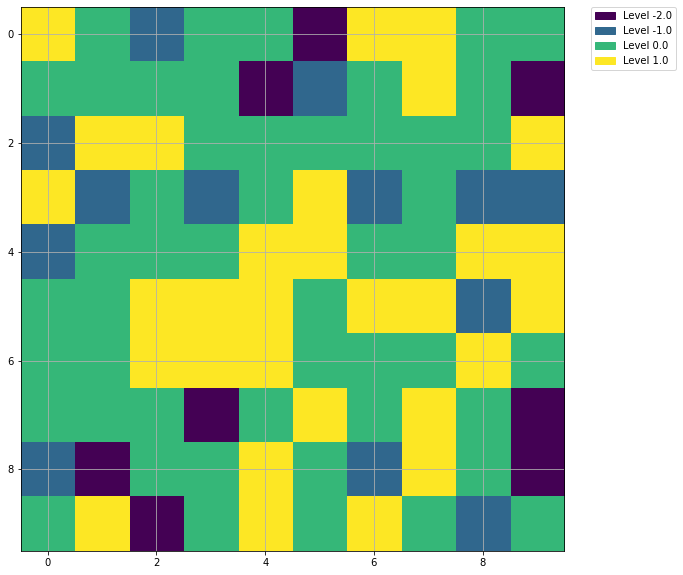

In [ ]:
plt.figure(figsize = (10,10))

values = np.unique(matriz_pvalores.ravel())

im = plt.imshow(matriz_pvalores, interpolation = 'none')

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.grid(True)
plt.show()

### Stepwise Regression

## Sklearn

### Managing results


In [61]:
# Creating Dataframe that contains results
results = pd.DataFrame({'Model':str,'PCA':int,'NMF':int,'Mean_Accuracy':float,
                        'STD_Accuracy':float,'Mean_AUC':float,
                        'STD_AUC':float},index = [0])

### Cross Validation

In [45]:
def CV(classifier,X,y,k):
  # Desired Metrics to include
  accuracy_list = []
  auc_list = []

  # Necessary Lists
  mean_tpr = 0.0
  mean_fpr = np.linspace(0, 1, 100)
  all_tpr = []
  tprs = []

  # Creating Stratified Fold for integration with CV
  skf = StratifiedKFold(n_splits = k)

  # Positive Rates
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i, (train, test) in enumerate(skf.split(X,y[0])):

    # Separate in train and test samples
    X_train = X.iloc[train,:]
    y_train = y.iloc[train,0]
    X_test = X.iloc[test,:]
    y_test = y.iloc[test,0]

    # Fitting the model
    classifier.fit(X_train,y_train)

    # Score function
    y_score = classifier.predict_proba(X_test)[:,1]

    # ROC AUC Curve
    fpr[i], tpr[i], thresholds = roc_curve(y_test,y_score)
    auc_list.append(auc(fpr[i],tpr[i]))
    aux = np.interp(mean_fpr, fpr[i], tpr[i])
    mean_tpr += aux
    mean_tpr[0] = 0.0
    tprs.append(aux)

  # Building Mean ROC AUC Curve
  mean_tpr /= k
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)

  return (accuracy_list, auc_list, fpr, tpr, tprs, mean_auc, mean_fpr, mean_tpr)

In [56]:
def plotrocauc(auc_list, fpr, tpr, tprs, mean_auc, mean_fpr, mean_tpr, path):
  # Create plot
  fig, ax = plt.subplots(figsize = (10,10))

  # Plot ROC AUC Curves
  for i in range(len(fpr)):
    ax.plot(fpr[i], tpr[i], lw = 3, alpha = 0.5,
            label='ROC fold %d (area = %0.2f)' % (i, auc_list[i]))

  # Plot diagonal
  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

  # Plot Mean ROC AUC
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(auc_list)
  ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=1)
  
  # Plot Confidence Interval
  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')
  
  # Settings
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
  ax.legend(loc="lower right")
  plt.show()

  # Save Figure
  filename = str(input('Type figure name: ')) + '.jpg'
  plt.savefig(os.path.join(path,filename))

### Model

#### Regular

In [60]:
%%capture
(accuracy_list, auc_list, fpr, tpr, tprs, mean_auc, mean_fpr, mean_tpr) = CV(LogisticRegression(),X,y,10)

# Create Directory
try:
    os.mkdir('figures/')
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise

path = 'figures/'

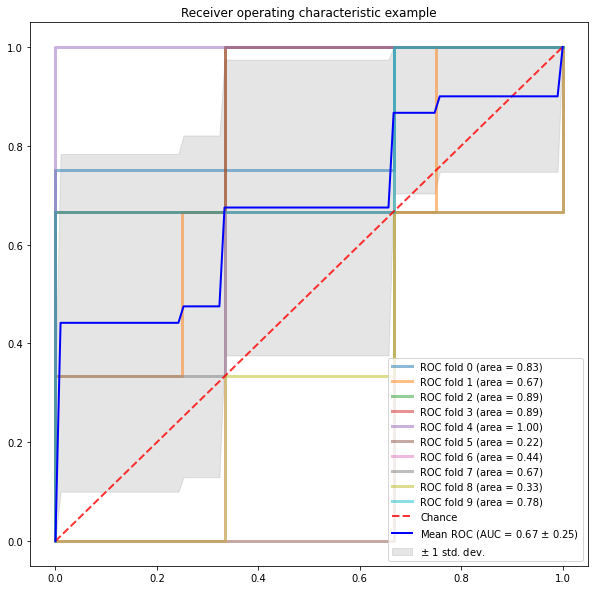

Type figure name: prueba1


<Figure size 432x288 with 0 Axes>

In [55]:
# ROC AUC Curves
plotrocauc(auc_list, fpr, tpr, tprs, mean_auc, mean_fpr, mean_tpr, path)

# Store Results
log_accuracy_mean = np.mean(accuracy_list)
log_accuracy_std = np.std(accuracy_list)
log_auc_mean = np.mean(auc_list)
log_auc_std = np.std(auc_list)
results = results.append({'Model':'Logistic','PCA':0,'NMF':0,
                          'Mean_Accuracy':log_accuracy_mean,
                          'STD_Accuracy':log_accuracy_std,
                          'Mean_AUC':log_auc_mean,
                          'STD_AUC':log_auc_std},ignore_index=True)

#### PCA

In [ ]:
%%capture
(accuracy_list, auc_list, fpr, tpr, tprs, mean_auc, mean_fpr, mean_tpr) = CV(LogisticRegression(),X_pca,y,10)

# Create Directory
try:
    os.mkdir('figures/')
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise

path = 'figures/'

In [ ]:
# ROC AUC Curves
plotrocauc(auc_list, fpr, tpr, tprs, mean_auc, mean_fpr, mean_tpr, path)

# Store Results
model_name = str(input('Type Model Name: '))
accuracy_mean = np.mean(accuracy_list)
accuracy_std = np.std(accuracy_list)
auc_mean = np.mean(auc_list)
auc_std = np.std(auc_list)
results = results.append({'Model':model_name,'PCA':1,'NMF':0,
                          'Mean_Accuracy':accuracy_mean,
                          'STD_Accuracy':accuracy_std,
                          'Mean_AUC':auc_mean,
                          'STD_AUC':auc_std},ignore_index=True)

#### NMF

In [ ]:
%%capture

# Regular
logistic = LogisticRegression()

# Cross Validation
cv_logistic = cross_validate(logistic,X,y[0],cv = skf,scoring = ['roc_auc','accuracy']);
acc_logistic = np.mean(cv_logistic['test_accuracy'])
auc_logistic = np.mean(cv_logistic['test_roc_auc'])

results = results.append({'Model':'Logistic','PCA':0,'NMF':0,'Mean_Accuracy':acc_logistic,'Mean_AUC':auc_logistic},ignore_index=True)

# # ROC AUC Curve
# logistic_roc_auc = roc_auc_score(y_test,logistic.predict(x_test))
# logistic_fpr, logistic_tpr, thresholds = roc_curve(y_test,logistic.predict_proba(x_train)[:,1])

# PCA
logistic_pca = LogisticRegression()

# Cross Validation
cv_logistic_pca = cross_validate(logistic_pca,X,y[0],cv = skf,scoring = ['roc_auc','accuracy']);
acc_logistic_pca = np.mean(cv_logistic_pca['test_accuracy'])
auc_logistic_pca = np.mean(cv_logistic_pca['test_roc_auc'])

results = results.append({'Model':'Logistic','PCA':1,'NMF':0,'Mean_Accuracy':acc_logistic_pca,'Mean_AUC':auc_logistic_pca},ignore_index=True)

# # ROC AUC Curve
# logistic_pca_roc_auc = roc_auc_score(y_test,logistic_pca.predict(x_test_pca))
# logistic_pca_fpr, logistic_pca_tpr, thresholds = roc_curve(y_test,logistic_pca.predict_proba(x_train_pca)[:,1])

# # # NMF
# logistic_nmf = LogisticRegression()

# # Cross Validation
# cv_logistic_nmf = cross_validate(logistic_nmf,X,y[0],cv = skf,scoring = ['roc_auc','accuracy'])
# acc_logistic_nmf = np.mean(cv_logistic_nmf['test_accuracy'])
# auc_logistic_nmf = np.mean(cv_logistic_nmf['test_roc_auc'])

# results = results.append({'Model':'Logistic','PCA':0,'NMF':1,'Mean_Accuracy':acc_logistic_nmf,'Mean_AUC':auc_logistic_nmf},ignore_index=True)

In [ ]:
results

#### ROC AUC Curve

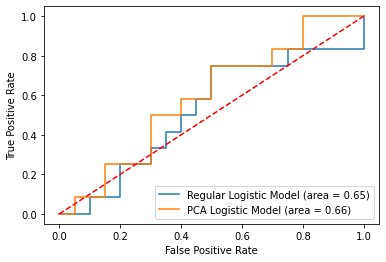

In [ ]:
plt.figure()
plt.plot(logistic_fpr,logistic_tpr,label = 'Regular Logistic Model (area = %0.2f)' % logistic_roc_auc)
plt.plot(logistic_pca_fpr,logistic_pca_tpr,label = 'PCA Logistic Model (area = %0.2f)' % logistic_pca_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### Random Forest

In [ ]:
%%capture

# Regular
rf = RandomForestClassifier()

# Cross Validation
cv_rf = cross_validate(rf,X,y[0],cv = skf,scoring = ['roc_auc','accuracy'])
acc_rf = np.mean(cv_rf['test_accuracy'])
auc_rf = np.mean(cv_rf['test_roc_auc'])

results = results.append({'Model':'RForest','PCA':0,'NMF':0,'Mean_Accuracy':acc_rf,'Mean_AUC':auc_rf},ignore_index=True)

# # ROC AUC Curve
# rf_roc_auc = roc_auc_score(y_test,rf.predict(x_test))
# rf_fpr, rf_tpr, thresholds = roc_curve(y_test,rf.predict_proba(x_train)[:,1])

# PCA
rf_pca = RandomForestClassifier()

# Cross Validation
cv_rf_pca = cross_validate(rf_pca,X,y[0],cv = skf,scoring = ['roc_auc','accuracy'])
acc_rf_pca = np.mean(cv_rf_pca['test_accuracy'])
auc_rf_pca = np.mean(cv_rf_pca['test_roc_auc'])

results = results.append({'Model':'RForest','PCA':1,'NMF':0,'Mean_Accuracy':acc_rf_pca,'Mean_AUC':auc_rf_pca},ignore_index=True)

# # ROC AUC Curve
# rf_pca_roc_auc = roc_auc_score(y_test,rf_pca.predict(x_test_pca))
# rf_pca_fpr, rf_pca_tpr, thresholds = roc_curve(y_test,rf_pca.predict_proba(x_train_pca)[:,1])

# # NMF
# rf_nmf = RandomForestClassifier()

# # Cross Validation
# cv_rf_nmf = cross_validate(rf_nmf,X,y[0],cv = skf,scoring = ['roc_auc','accuracy'])
# acc_rf_nmf = np.mean(cv_rf_nmf['test_accuracy'])
# auc_rf_nmf = np.mean(cv_rf_nmf['test_roc_auc'])

# results = results.append({'Model':'RForest','PCA':0,'NMF':1,'Mean_Accuracy':acc_rf_pca,'Mean_AUC':auc_rf_pca},ignore_index=True)

,Model,PCA,NMF,Score,Confusion_Matrix,ROC_AUC_Scores
0,Logistic,0,0,0.62500,"[[11, 3], [9, 9]]",0.650000
1,Logistic,1,0,0.65625,"[[13, 4], [7, 8]]",0.658333
2,RForest,0,0,0.59375,"[[12, 5], [8, 7]]",0.591667
3,RForest,1,0,0.40625,"[[1, 0], [19, 12]]",0.525000


In [ ]:
results

#### ROC AUC Curve

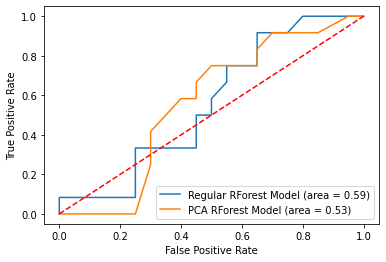

In [ ]:
plt.figure()
plt.plot(rf_fpr,rf_tpr,label = 'Regular RForest Model (area = %0.2f)' % rf_roc_auc)
plt.plot(rf_pca_fpr,rf_pca_tpr,label = 'PCA RForest Model (area = %0.2f)' % rf_pca_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### KNN

In [ ]:
%%capture

# Regular
knn = KNeighborsClassifier()

# Cross Validation
cv_knn = cross_validate(knn,X,y[0],cv = skf,scoring = ['roc_auc','accuracy'])
acc_knn = np.mean(cv_knn['test_accuracy'])
auc_knn = np.mean(cv_knn['test_roc_auc'])

results = results.append({'Model':'RForest','PCA':0,'NMF':0,'Mean_Accuracy':acc_knn,'Mean_AUC':auc_knn},ignore_index=True)

# # ROC AUC Curve
# knn_roc_auc = roc_auc_score(y_test,knn.predict(x_test))
# knn_fpr, knn_tpr, thresholds = roc_curve(y_test,knn.predict_proba(x_train)[:,1])

# PCA
knn_pca = KNeighborsClassifier()

# Cross Validation
cv_knn_pca = cross_validate(knn_pca,X,y[0],cv = skf,scoring = ['roc_auc','accuracy'])
acc_knn_pca = np.mean(cv_knn_pca['test_accuracy'])
auc_knn_pca = np.mean(cv_knn_pca['test_roc_auc'])

results = results.append({'Model':'RForest','PCA':1,'NMF':0,'Mean_Accuracy':acc_knn_pca,'Mean_AUC':auc_knn_pca},ignore_index=True)

# # ROC AUC Curve
# knn_pca_roc_auc = roc_auc_score(y_test,knn_pca.predict(x_test_pca))
# knn_pca_fpr, knn_pca_tpr, thresholds = roc_curve(y_test,knn_pca.predict_proba(x_train_pca)[:,1])

# # NMF
# knn_nmf = KNeighborsClassifier()

# # Cross Validation
# cv_knn_nmf = cross_validate(knn_nmf,X,y[0],cv = skf,scoring = ['roc_auc','accuracy'])
# acc_knn_nmf = np.mean(cv_knn_nmf['test_accuracy'])
# auc_knn_nmf = np.mean(cv_knn_nmf['test_roc_auc'])

# results = results.append({'Model':'RForest','PCA':0,'NMF':1,'Mean_Accuracy':acc_knn_nmf,'Mean_AUC':auc_knn_nmf},ignore_index=True)

,Model,PCA,NMF,Score,Confusion_Matrix,ROC_AUC_Scores
0,Logistic,0,0,0.62500,"[[11, 3], [9, 9]]",0.650000
1,Logistic,1,0,0.65625,"[[13, 4], [7, 8]]",0.658333
2,RForest,0,0,0.59375,"[[12, 5], [8, 7]]",0.591667
3,RForest,1,0,0.40625,"[[1, 0], [19, 12]]",0.525000
4,KNN,0,0,0.40625,"[[3, 2], [17, 10]]",0.491667
5,KNN,1,0,0.40625,"[[3, 2], [17, 10]]",0.491667


In [ ]:
results

#### ROC AUC Curve

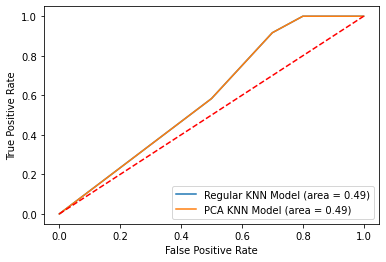

In [ ]:
plt.figure()
plt.plot(knn_fpr,knn_tpr,label = 'Regular KNN Model (area = %0.2f)' % knn_roc_auc)
plt.plot(knn_pca_fpr,knn_pca_tpr,label = 'PCA KNN Model (area = %0.2f)' % knn_pca_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### Naive Bayes

In [ ]:
%%capture

# Regular
nb = GaussianNB()

# Cross Validation
cv_nb = cross_validate(nb,X,y[0],cv = skf,scoring = ['roc_auc','accuracy'])
acc_nb = np.mean(cv_nb['test_accuracy'])
auc_nb = np.mean(cv_nb['test_roc_auc'])

results = results.append({'Model':'RForest','PCA':0,'NMF':0,'Mean_Accuracy':acc_nb,'Mean_AUC':auc_nb},ignore_index=True)

# # ROC AUC Curve
# nb_roc_auc = roc_auc_score(y_test,nb.predict(x_test))
# nb_fpr, nb_tpr, thresholds = roc_curve(y_test,nb.predict_proba(x_train)[:,1])

# PCA
nb_pca = GaussianNB()

# Cross Validation
cv_nb_pca = cross_validate(nb_pca,X,y[0],cv = skf,scoring = ['roc_auc','accuracy'])
acc_nb_pca = np.mean(cv_nb_pca['test_accuracy'])
auc_nb_pca = np.mean(cv_nb_pca['test_roc_auc'])

results = results.append({'Model':'RForest','PCA':1,'NMF':0,'Mean_Accuracy':acc_nb_pca,'Mean_AUC':auc_nb_pca},ignore_index=True)

# # ROC AUC Curve
# nb_pca_roc_auc = roc_auc_score(y_test,nb_pca.predict(x_test_pca))
# nb_pca_fpr, nb_pca_tpr, thresholds = roc_curve(y_test,nb_pca.predict_proba(x_train_pca)[:,1])

# # NMF
# nb_nmf = GaussianNB()

# # Cross Validation
# cv_nb_nmf = cross_validate(nb_nmf,X,y[0],cv = skf,scoring = ['roc_auc','accuracy'])
# acc_nb_nmf = np.mean(cv_nb_nmf['test_accuracy'])
# auc_nb_nmf = np.mean(cv_nb_nmf['test_roc_auc'])

# results = results.append({'Model':'RForest','PCA':0,'NMF':1,'Mean_Accuracy':acc_nb_nmf,'Mean_AUC':auc_nb_nmf},ignore_index=True)

,Model,PCA,NMF,Score,Confusion_Matrix,ROC_AUC_Scores
0,Logistic,0,0,0.62500,"[[11, 3], [9, 9]]",0.650000
1,Logistic,1,0,0.65625,"[[13, 4], [7, 8]]",0.658333
2,RForest,0,0,0.59375,"[[12, 5], [8, 7]]",0.591667
3,RForest,1,0,0.40625,"[[1, 0], [19, 12]]",0.525000
4,KNN,0,0,0.40625,"[[3, 2], [17, 10]]",0.491667
5,KNN,1,0,0.40625,"[[3, 2], [17, 10]]",0.491667
6,NaiveB,0,0,0.59375,"[[14, 7], [6, 5]]",0.558333
7,NaiveB,1,0,0.53125,"[[10, 5], [10, 7]]",0.541667


In [ ]:
results

#### ROC AUC Curve

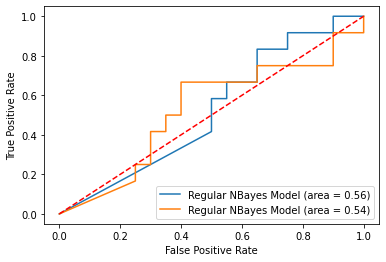

In [ ]:
plt.figure()
plt.plot(nb_fpr,nb_tpr,label = 'Regular NBayes Model (area = %0.2f)' % nb_roc_auc)
plt.plot(nb_pca_fpr,nb_pca_tpr,label = 'Regular NBayes Model (area = %0.2f)' % nb_pca_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
results

,Model,PCA,NMF,Score,Confusion_Matrix,ROC_AUC_Scores
0,Logistic,0,0,0.62500,"[[11, 3], [9, 9]]",0.650000
1,Logistic,1,0,0.65625,"[[13, 4], [7, 8]]",0.658333
2,RForest,0,0,0.59375,"[[12, 5], [8, 7]]",0.591667
3,RForest,1,0,0.40625,"[[1, 0], [19, 12]]",0.525000
4,KNN,0,0,0.40625,"[[3, 2], [17, 10]]",0.491667
5,KNN,1,0,0.40625,"[[3, 2], [17, 10]]",0.491667
6,NaiveB,0,0,0.59375,"[[14, 7], [6, 5]]",0.558333
7,NaiveB,1,0,0.53125,"[[10, 5], [10, 7]]",0.541667


# ROC AUC Curves

## Regular

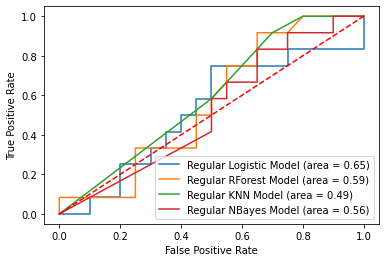

In [ ]:
plt.figure()
plt.plot(logistic_fpr,logistic_tpr,label = 'Regular Logistic Model (area = %0.2f)' % logistic_roc_auc)
plt.plot(rf_fpr,rf_tpr,label = 'Regular RForest Model (area = %0.2f)' % rf_roc_auc)
plt.plot(knn_fpr,knn_tpr,label = 'Regular KNN Model (area = %0.2f)' % knn_roc_auc)
plt.plot(nb_fpr,nb_tpr,label = 'Regular NBayes Model (area = %0.2f)' % nb_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## PCA

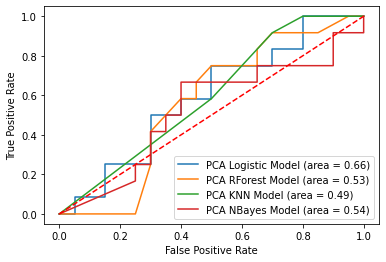

In [ ]:
plt.figure()
plt.plot(logistic_pca_fpr,logistic_pca_tpr,label = 'PCA Logistic Model (area = %0.2f)' % logistic_pca_roc_auc)
plt.plot(rf_pca_fpr,rf_pca_tpr,label = 'PCA RForest Model (area = %0.2f)' % rf_pca_roc_auc)
plt.plot(knn_pca_fpr,knn_pca_tpr,label = 'PCA KNN Model (area = %0.2f)' % knn_pca_roc_auc)
plt.plot(nb_pca_fpr,nb_pca_tpr,label = 'PCA NBayes Model (area = %0.2f)' % nb_pca_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Storing Results

In [ ]:
file_name = str(input('Enter the filename: '))
comment = str(input('Enter the experiment description:'))

results.to_csv(file_name + '.csv')

np.savetxt(file_name + '.txt',[comment], fmt = '%10s')

Enter the filename: prueba2
Enter the experiment description:descripcion prueba2


In [ ]:
shutil.copy(file_name + '.csv', '/content/drive/MyDrive/sdw_classification/experiments/')
shutil.copy(file_name + '.txt', '/content/drive/MyDrive/sdw_classification/experiments/')
os.remove(file_name + '.csv')
os.remove(file_name + '.txt')

# Manage Files

In [ ]:
def remove_folders():
  
  # Rename directories
  os.rename('data/cardboard','data/cardboardprocessed')
  os.rename('data/metal','data/metalprocessed')

  # Ziping the folders
  shutil.make_archive('cardboardprocessed','zip','data/cardboardprocessed')
  shutil.make_archive('metalprocessed','zip','data/metalprocessed')

  # Copying zip folders
  shutil.copy('cardboardprocessed.zip','/content/drive/MyDrive/sdw_classification/datasets/compressed')
  shutil.copy('metalprocessed.zip','/content/drive/MyDrive/sdw_classification/datasets/compressed')

  # Removing folders
  os.remove('cardboardprocessed.zip')
  os.remove('metalprocessed.zip')
  shutil.rmtree('data')
  shutil.rmtree('train')
  shutil.rmtree('test')

In [ ]:
remove_folders()

FileNotFoundError: ignored

Text(0.5, 1.05, 'Correlation Matrix')

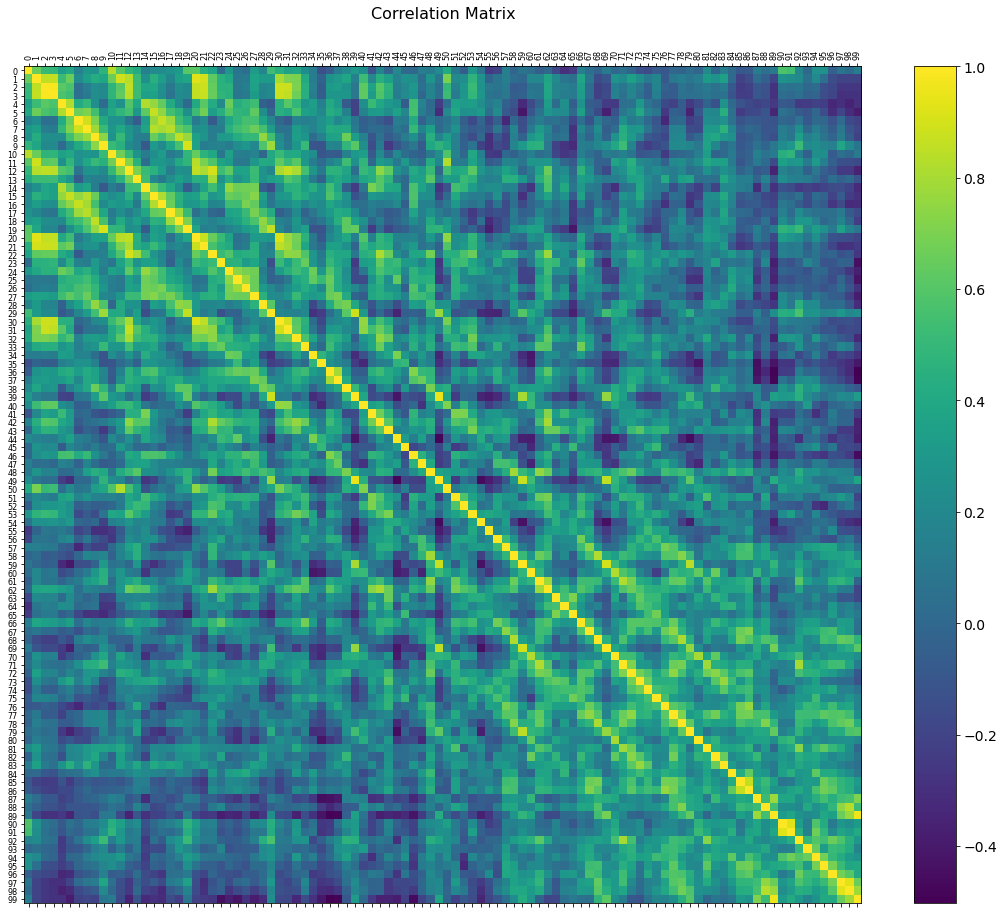

In [ ]:
f = plt.figure(figsize=(19, 15))
plt.matshow(x_train.corr(), fignum=f.number)
plt.xticks(range(x_train.shape[1]), x_train.columns, fontsize=8, rotation=90)
plt.yticks(range(x_train.shape[1]), x_train.columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)